In [1]:
cores = '4'
strains = 'https://evocellnet.github.io/ecoref/data/strains.tsv'
phenotypes = 'https://evocellnet.github.io/ecoref/data/phenotypic_data.tsv'
pathogenicity = '../data/phenotypes/phenotypes.tsv'
gdir = '../data/genomes'
filtered = '../out/associations/summary_cont_lmm_kmer.tsv'
rtab = '../out/roary/gene_presence_absence.Rtab'

In [2]:
cores = int(cores)

In [3]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [4]:
import os
import random
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import impute
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [5]:
def match(x, y, c,
          xcolumn='s-scores',
          ycolumn='killed'):
    j = x.loc[c, xcolumn]
    k = y.loc[j.index, ycolumn]
    idx = j.index.intersection(k.index)
    if len(idx) == 0:
        return np.nan, np.nan
    j = j.loc[idx]
    k = k.loc[idx]
    return j, k

def correlate(x, y, c,
              method='pearson',
              xcolumn='s-scores',
              ycolumn='killed'):
    j, k = match(x, y, c, xcolumn, ycolumn)
    if method == 'pearson':
        return stats.pearsonr(j, k)
    else:
        return stats.spearmanr(j, k)

In [6]:
def rndmfrst(x, y, xcolumn='s-scores', ycolumn='phenotype'):
    c = x[xcolumn].unstack()
    c = pd.DataFrame(impute.SimpleImputer().fit_transform(c),
                     index=c.index,
                     columns=c.columns).T
    c['mouse'] = y.loc[c.index, ycolumn]
    
    df = c[sorted(set(c.columns) - {'mouse'})]
    target = c['mouse']
    
    cv = model_selection.StratifiedShuffleSplit(n_splits=1,
                                                test_size=0.33,
                                                random_state=np.random.RandomState(42))
    train_idx, test_idx = next(cv.split(df, target))
    
    df_train, target_train = df.iloc[train_idx], target[train_idx]
    df_test, target_test = df.iloc[test_idx], target[test_idx]
    
    param_grid = {'n_estimators': [int(x) for x in np.logspace(1, 3, 6)],
                  'max_features': range(int(np.sqrt(df.shape[1])), int(df.shape[1] *0.7), 5)}

    clf = RandomForestClassifier(random_state=np.random.RandomState(42))
    grid_search = model_selection.GridSearchCV(clf,
                                               param_grid=param_grid,
                                               cv=model_selection.StratifiedShuffleSplit(n_splits=10,
                                                              test_size=0.33,
                                                              random_state=np.random.RandomState(42)),
                                               scoring='f1',
                                               n_jobs=cores)
    grid_search.fit(df_train, target_train)
    
    clf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                 max_features=grid_search.best_params_['max_features'],
                                 random_state=np.random.RandomState(42))
    clf.fit(df_train, target_train)
    predict_test = pd.Series(clf.predict(df_test),
                             index=target_test.index,
                             name='prediction')
    combined = target_test.to_frame().join(predict_test.to_frame())
    print(metrics.f1_score(combined['mouse'],
                           combined['prediction']),
          grid_search.best_score_)
    
    return clf, combined, df_test

In [7]:
f = pd.read_table(filtered,
                  index_col=0)
f = f[f['specific_hits'] > 0]
r = pd.read_table(rtab, index_col=0)
r = r.loc[f.index].copy(deep=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [8]:
hpi = r.sum()
hpi.name = 'hpi'
hpi = hpi.to_frame()
hpi['present'] = [1 if x >= 11 
                  else 0
                  for x in hpi['hpi'].values]

In [9]:
exclude = {'ECOR-03', 'ECOR-05', 'ECOR-06', 'ECOR-07',
           'ECOR-08', 'ECOR-22', 'ECOR-23', 'ECOR-30',
           'ECOR-31', 'ECOR-32', 'ECOR-33', 'ECOR-35',
           'ECOR-36', 'ECOR-37', 'ECOR-43', 'ECOR-44',
           'ECOR-45', 'ECOR-47', 'ECOR-48', 'ECOR-49',
           'ECOR-51', 'ECOR-55', 'ECOR-56', 'ECOR-61',
           'ECOR-64', 'ECOR-65', 'ECOR-66', 'ECOR-68',
           'ECOR-71', 'IAI29', 'IAI64', 'NILS80'}
genomes = {x.split('.')[0]
           for x in os.listdir(gdir)
           if x.endswith('.fasta')} - exclude

In [10]:
s = pd.read_table(strains, index_col=1)
s.index = [x.replace(' ', '')
           if x.startswith('NILS')
           else x
           for x in s.index]
s = s.loc[[k for k,v in s.T.iteritems()
           if k in genomes
           and v.values[0] != 'NT12008']][['Strain Identifier', 'Full Strain Name After Genome Analysis']].dropna()
s = s['Strain Identifier']
s = s.reset_index().set_index(
    'Strain Identifier'
    ).drop('NT12008').reset_index().set_index(
    'index')['Strain Identifier']
d = {v: k
     for k, v in s.iteritems()}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [11]:
p = pd.read_table(phenotypes).set_index('strain')
p.index = [d.get(x, x)
           for x in p.index]
p.index.name = 'strain'
p = p.reset_index().set_index(['strain', 'condition'])
p = p.loc[s.index]
p = p.reset_index().set_index(['condition', 'strain'])
p = p.sort_index()
p['signed-qvalue'] = [np.sign(x) * -np.log10(y)
                      for x, y, z in p.values]
# idx = p.groupby('condition')['growth-defect-phenotype'
#         ].sum()[p.groupby('condition')[
#       'growth-defect-phenotype'].sum() > 0].index
# p = p.loc[idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [12]:
k = pd.read_table(pathogenicity,
                  index_col=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [13]:
res = []
for c in {x[0] for x in p.index}:
    r, pval = correlate(p, k, c)
    res.append((c, 'pearson', 's-score', r, pval))
    r, pval = correlate(p, k, c, method='spearman')
    res.append((c, 'spearman', 's-score', r, pval))
    r, pval = correlate(p, k, c, xcolumn='signed-qvalue')
    res.append((c, 'pearson', 'signed-qvalue', r, pval))
    r, pval = correlate(p, k, c, method='spearman', xcolumn='signed-qvalue')
    res.append((c, 'spearman', 'signed-qvalue', r, pval))
    r, pval = correlate(p, hpi, c, ycolumn='hpi')
    res.append((c, 'pearson', 's-score.hpi', r, pval))
    r, pval = correlate(p, hpi, c, method='spearman', ycolumn='hpi')
    res.append((c, 'spearman', 's-score.hpi', r, pval))
    r, pval = correlate(p, hpi, c, xcolumn='signed-qvalue', ycolumn='hpi')
    res.append((c, 'pearson', 'signed-qvalue.hpi', r, pval))
    r, pval = correlate(p, hpi, c, method='spearman', xcolumn='signed-qvalue', ycolumn='hpi')
    res.append((c, 'spearman', 'signed-qvalue.hpi', r, pval))
r = pd.DataFrame(res,
                 columns=['condition',
                          'method',
                          'column',
                          'r',
                          'p'])

In [14]:
r.to_csv('correlations.tsv', index=False, sep='\t')

In [15]:
cd = {'NACL.RT': 'NaCl 400$nM$',
      'PH5.RT': 'pH5',
      'PH9.BILESALTS': 'pH9 + Bile salts',
      'PH9C.UV': 'pH9 + UV light',
      'PVP.0P04': 'PVP 0.04$\mu g/ml$',
      'A22.CHIR090': 'A22 + CHIR-090',
      'THIOLUTIN.10': r'Thiolutin 10$\mu g/ml$',
      'OXACILLIN.0P5UM': r'Oxacillin 0.05$\mu M$',
      'CIPROFLOXACIN.0P001UM': 'Ciprofloxacin 0.001$\mu M$',
      'RIFAMPICIN.1UM': 'Rifampicin 1$\mu M$',
      'RIFAMPICIN.2UM': 'Rifampicin 2$\mu M$',
      'INDOLE.TOBRAMYCIN': 'Indole + Tobramycin',
      'TEICOPLANIN.10': 'Teicoplanin 10$\mu g/ml$',
      'INDOLE.CEFSULODIN': 'Indole + Cefsulodin',
      'CERULENIN.1UM': 'Cerulenin 1$\mu M$',
      'COLICINM.0P4': 'Colicin-M 0.4$\mu g/ml$',
      'PENTAACETICACID.15': 'Pentetic acid 15$\mu g/ml$',
      'AMOXICILLIN.0P5UM': 'Amoxicillin 0.5$\mu M$',
      'PYOCYANIN.0P2UM': 'Pyocyanin 0.2$\mu M$',
      'MEROPENEM.0P03': 'Meropenem 0.03$\mu g/ml$',
      'PARAQUAT.10UM': 'Paraquat 10$\mu M$',
      'DM.GLUCOSE25MM': 'Glucose 25$mM$',
      'PIERICIDIN.20': 'Piericidin 20$\mu g/ml$',
      'TETRACYCLINE.0P5UM': 'Tetracycline 0.5$\mu M$',
      'TETRACYCLINE.0P25UM': 'Tetracycline 0.25$\mu M$',
      'INDOLE.40C': 'Indole 40$^\circ C$',
      'SULFAMONOMETHOXINE.RIFAMPICIN': 'Sulfamonomethoxine + Rifampicin',
      'PH9.NITRATEK': 'pH9 + Nitratek',
      'PH5.FUMARATE': 'pH5 + Fumarate',
      'FUMARATE.40MM': 'Fumarate 40$mM$'}

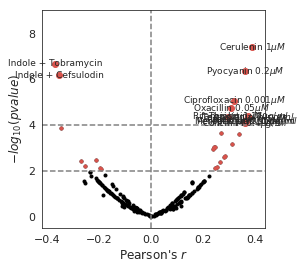

In [16]:
plt.figure(figsize=(4, 4))

r1 = r[(r['method'] == 'pearson') &
       (r['column'] == 's-score')].copy(deep=True)
r1 = r1.set_index('condition')

plt.scatter(r1['r'],
            -np.log10(r1['p']),
            color='k',
            marker='.',
            rasterized=True)
r2 = r1[-np.log10(r1['p']) > 4]
plt.scatter(r2['r'],
            -np.log10(r2['p']),
            color=sns.xkcd_rgb['pale red'],
            marker='o')
r2 = r1[(-np.log10(r1['p']) > 2) &
        (-np.log10(r1['p']) < 4)]
plt.scatter(r2['r'],
            -np.log10(r2['p']),
            color=sns.xkcd_rgb['pale red'],
            marker='.')

texts = []
for t, v in r1[-np.log10(r1['p']) >= 4].iterrows():
    texts.append(plt.text(v['r'],
                          -np.log10(v['p']),
                          cd.get(t, t),
                          ha='center',
                          va='center',
                          fontdict={'size': 9}))
# adjust_text(texts,
#             arrowprops=dict(arrowstyle='-', color='k'),
#             force_points=1)

plt.ylim(-0.5, 9)

plt.xlabel('Pearson\'s $r$')
plt.ylabel('$-log_{10}(pvalue)$')

plt.axvline(0,
            color='grey',
            ls='dashed')
plt.axhline(2,
            color='grey',
            ls='dashed')
plt.axhline(4,
            color='grey',
            ls='dashed')

plt.savefig('volcano_1.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('volcano_1.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

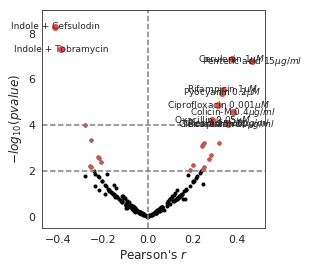

In [17]:
plt.figure(figsize=(4, 4))

r1 = r[(r['method'] == 'pearson') &
       (r['column'] == 's-score.hpi')].copy(deep=True)
r1 = r1.set_index('condition')

plt.scatter(r1['r'],
            -np.log10(r1['p']),
            color='k',
            marker='.',
            rasterized=True)
r2 = r1[-np.log10(r1['p']) > 4]
plt.scatter(r2['r'],
            -np.log10(r2['p']),
            color=sns.xkcd_rgb['pale red'],
            marker='o')
r2 = r1[(-np.log10(r1['p']) > 2) &
        (-np.log10(r1['p']) < 4)]
plt.scatter(r2['r'],
            -np.log10(r2['p']),
            color=sns.xkcd_rgb['pale red'],
            marker='.')

texts = []
for t, v in r1[-np.log10(r1['p']) >= 4].iterrows():
    texts.append(plt.text(v['r'],
                          -np.log10(v['p']),
                          cd.get(t, t),
                          ha='center',
                          va='center',
                          fontdict={'size': 9}))
# adjust_text(texts,
#             arrowprops=dict(arrowstyle='-', color='k'),
#             force_points=1)

plt.ylim(-0.5, 9)

plt.xlabel('Pearson\'s $r$')
plt.ylabel('$-log_{10}(pvalue)$')

plt.axvline(0,
            color='grey',
            ls='dashed')
plt.axhline(2,
            color='grey',
            ls='dashed')
plt.axhline(4,
            color='grey',
            ls='dashed')

plt.savefig('volcano_2.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('volcano_2.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [18]:
clf1, combined1, df_test1 = rndmfrst(p, k, 's-scores')

0.8 0.7698214675763432


In [19]:
clf2, combined2, df_test2 = rndmfrst(p, hpi, 's-scores', 'present')

0.8723404255319148 0.853233691365726


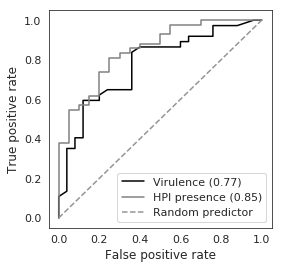

In [20]:
plt.figure(figsize=(4, 4))

fpr, tpr, _ = metrics.roc_curve(combined1['mouse'],
                                clf1.predict_proba(df_test1)[:, 1])
plt.plot(fpr, tpr,
         'k-',
         label='Virulence (%.2f)' % metrics.auc(fpr, tpr))

fpr, tpr, _ = metrics.roc_curve(combined2['mouse'],
                                clf2.predict_proba(df_test2)[:, 1])
plt.plot(fpr, tpr,
         '-',
         color='grey',
         label='HPI presence (%.2f)' % metrics.auc(fpr, tpr))

plt.plot([0, 1],
         [0, 1],
         '--',
         color=sns.xkcd_rgb['grey'],
         label='Random predictor')

plt.legend(frameon=True,
           loc='lower right')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.savefig('roc_auc.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('roc_auc.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

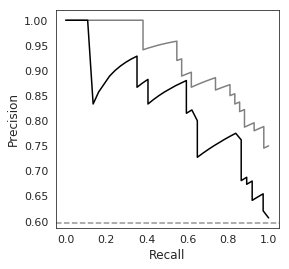

In [21]:
plt.figure(figsize=(4, 4))

prec, rec, _ = metrics.precision_recall_curve(combined1['mouse'],
                                              clf1.predict_proba(df_test1)[:, 1])
plt.plot(rec, prec,
         'k-',
         label='Virulence')

prec, rec, _ = metrics.precision_recall_curve(combined2['mouse'],
                                              clf2.predict_proba(df_test2)[:, 1])
plt.plot(rec, prec,
         '-',
         color='grey',
         label='HPI presence',
         zorder=0)

plt.axhline(combined1[combined1['mouse'] == 1].shape[0] / combined1.shape[0],
            color=sns.xkcd_rgb['grey'],
            ls='dashed',
            label='Random predictor')

# plt.legend(frameon=True,
#            loc='lower right')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.savefig('prec_rec.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('prec_rec.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [22]:
fi1 = pd.Series(clf1.feature_importances_,
                p['s-scores'].unstack().T.columns)
fi1.name = 'Virulence'
fi2 = pd.Series(clf2.feature_importances_,
                p['s-scores'].unstack().T.columns)
fi2.name = 'HPI presence'

In [23]:
fi = fi1.to_frame().join(fi2.to_frame())
fi = fi.sort_values('Virulence',
                    ascending=False).head(15)
fi = fi.stack().reset_index()
fi.columns = ['Condition',
              'Predictor',
              'Feature importance']
fi['Condition'] = [cd.get(x, x)
                   for x in fi['Condition']]

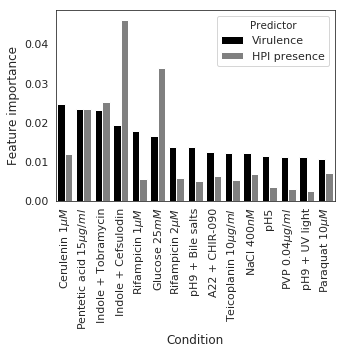

In [24]:
plt.figure(figsize=(5, 3.5))

sns.barplot(data=fi,
            x='Condition',
            y='Feature importance',
            hue='Predictor',
            palette=['k',
                     'grey'])

plt.xticks(rotation=90)

plt.savefig('feature_importance.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('feature_importance.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [25]:
fi = fi1.to_frame().join(fi2.to_frame())
fi = fi.sort_values('Virulence',
                    ascending=False)
fi.to_csv('feature_importance.tsv',
          sep='\t')

In [26]:
fi1 = pd.Series(clf1.feature_importances_,
                p['s-scores'].unstack().T.columns)
fi1.name = 'Virulence'
fi2 = pd.Series(clf2.feature_importances_,
                p['s-scores'].unstack().T.columns)
fi2.name = 'HPI presence'

In [27]:
fi = fi1.to_frame().join(fi2.to_frame())
fi = fi.sort_values('HPI presence',
                    ascending=False).head(15)
fi = fi.stack().reset_index()
fi.columns = ['Condition',
              'Predictor',
              'Feature importance']
fi['Condition'] = [cd.get(x, x)
                   for x in fi['Condition']]

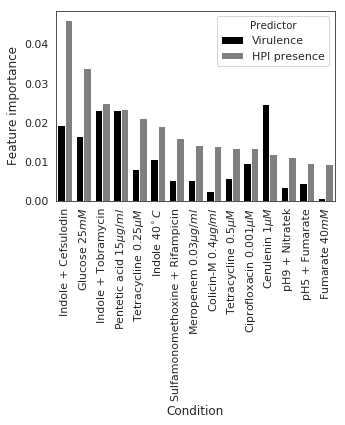

In [28]:
plt.figure(figsize=(5, 3.5))

sns.barplot(data=fi,
            x='Condition',
            y='Feature importance',
            hue='Predictor',
            palette=['k',
                     'grey'])

plt.xticks(rotation=90)

plt.savefig('feature_importance_2.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('feature_importance_2.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);